In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%pylab inline
plt.style.use("bmh")

plt.rcParams["figure.figsize"] = (6,6)

import numpy as np
import pandas as pd
import json
import tqdm
import pathlib
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
RS = 77
DATA_DIR = pathlib.Path("./")

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

TensorFlow 2.x selected.
Populating the interactive namespace from numpy and matplotlib


In [0]:
train_data = pd.read_csv("https://sibur.ai-community.com/files/uploads/1751c781501264f1f49537054f901dc2/activity_train.csv.zip",
                         parse_dates=["date"], index_col="date",
                         compression="zip") #, dtype=np.float32)
test_data = pd.read_csv("https://sibur.ai-community.com/files/uploads/511e69d37295aabf89fc0cce5e8a2de5/activity_test.csv.zip",
                         parse_dates=["date"], index_col="date",
                         compression="zip") #, dtype=np.float32)
activity_test_target = pd.read_csv("https://sibur.ai-community.com/files/uploads/9bef2749c625cf89373bcb4861962c14/activity_test_timestamps.csv",
                         parse_dates=["date"], index_col="date")
atactic_test_target = pd.read_csv("https://sibur.ai-community.com/files/uploads/9bef2749c625cf89373bcb4861962c14/activity_test_timestamps.csv",
                         parse_dates=["date"], index_col="date")

In [0]:
data = pd.concat([train_data[test_data.columns], test_data])
train_targets = train_data[["activity", "atactic_1", "atactic_2", "atactic_3"]].copy()

In [0]:
data.drop(['f28'], axis=1, inplace=True)
#full_data = data[['f4', 'f12']]
full_data = data

In [0]:
PERIODS = ["1H", "3H", "6H"]
AGGREGATES = ["mean", "median", "std", "max", "min"]

all_features = []

for period in tqdm.tqdm_notebook(PERIODS):
    for agg in AGGREGATES:
        rolling_features = data.rolling(period).aggregate(agg)
        rolling_features.rename(lambda x: "_".join([x, period, agg]), axis=1, inplace=True)
        all_features.append(rolling_features)
all_features = pd.concat(all_features, axis=1)
full_data = data.join(all_features)

In [0]:
activity_data = train_targets[["activity"]].join(full_data.shift(6, freq="H"))
activity_data = activity_data[activity_data.notnull().all(axis=1)]

#activity_data["month"] = activity_data.index.month
#activity_data["day"] = activity_data.index.day
#activity_data["hour"] = activity_data.index.hour
#activity_data["minute"] = activity_data.index.minute

FTS_COLS = activity_data.columns[1:]
TARGET = "activity"

## Тривиальные бенчмарки

In [0]:
print(f"MAPE (last known value, cross-validation set): {100 * mape(cv_data['activity'], tr_data['activity'].iloc[-1]):.2f}%")
print(f"MAPE (median, cross-validation set): {100 * mape(cv_data['activity'], tr_data['activity'].median()):.2f}%")

MAPE (last known value, cross-validation set): 10.99%
MAPE (median, cross-validation set): 13.54%


In [0]:
naive_baseline = activity_test_target.copy()
naive_baseline["rubber"] = tr_data['activity'].iloc[-1]
naive_baseline.to_csv(DATA_DIR.joinpath("activity_naive_baseline.csv"))

## Модель

In [0]:
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score

In [0]:
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)

In [0]:
corrs = activity_data.corr().loc[TARGET, FTS_COLS]
corrs.abs().sort_values(ascending=False).head(5)

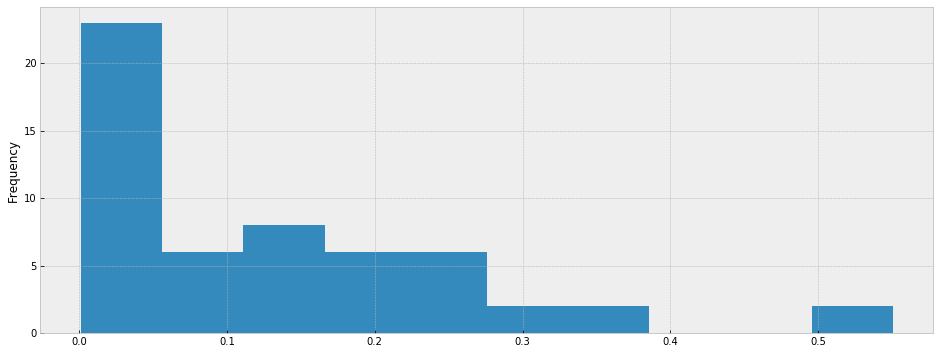

In [0]:
corrs.abs().plot(kind="hist")

In [0]:
FTS_COLS = corrs[corrs.abs()>=0.2].index
FTS_COLS

Index(['f6', 'f7', 'f8', 'f14', 'f15', 'f22', 'f23', 'f24', 'f25', 'f31',
       'f35', 'f42', 'f46', 'f47'],
      dtype='object')

MAPE (training set): 10.75%
MAPE (cross-validation set): 10.73%


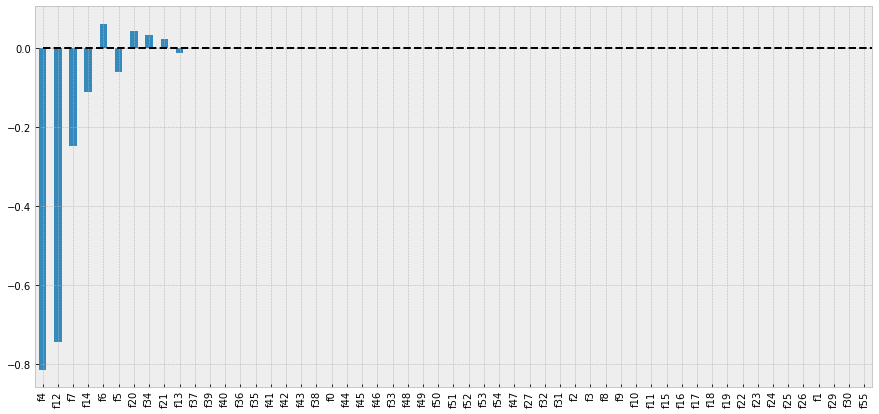

In [25]:
import sklearn
from sklearn import linear_model
from xgboost import XGBRegressor 

def plotCoefficients(model, columns):
    coefs = pd.DataFrame(model.coef_, columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

    return coefs

tr_data = activity_data[:"2018-10-13"].copy()
cv_data = activity_data["2018-10-14":].copy()

center, scale = tr_data[FTS_COLS].mean().values, tr_data[FTS_COLS].std().values
trn = (tr_data[FTS_COLS].values - center)/scale
cvn = (cv_data[FTS_COLS].values - center)/scale

y_trn = tr_data[TARGET].values
y_cv =  cv_data[TARGET].values

lr = sklearn.linear_model.ElasticNet(random_state=RS) #LinearRegression() #Ridge() #Lasso() #ElasticNetCV() #SGDRegressor() #XGBRegressor()
lr.fit(trn, y_trn)

tr_preds = lr.predict(trn)
cv_preds = lr.predict(cvn)

tr_preds = pd.Series(tr_preds.flatten(), index=tr_data.index, name="activity_pred").sort_index()
cv_preds = pd.Series(cv_preds.flatten(), index=cv_data.index, name="activity_pred")

print(f"MAPE (training set): {100 * mape(tr_data.activity.values, tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(cv_data.activity.values, cv_preds.values):.2f}%")

coefs = plotCoefficients(lr, FTS_COLS)
#FTS_COLS = coefs.index[np.abs(coefs.coef) > 10]

In [0]:
# 6-6-4 = 8.05% 0.2551/hyber
# 6-6-0 = 7.76% 0.2473/Hyber
# 7-7-0 = 7.79% 0.2406/Hyber
# 7-7-7 = 8.58%
def build_model():

  model = keras.Sequential([
      layers.Input(shape=len(FTS_COLS)),
      layers.Reshape(target_shape=(1, len(FTS_COLS))),
      layers.LSTM(7, return_sequences=True),
      layers.LSTM(7),
      layers.Flatten(),
      layers.Dense(1)
    ])

  model3 = keras.Sequential([
      layers.Input(shape=(len(FTS_COLS))),
      #layers.Reshape(target_shape=(1, len(FTS_COLS))),
      layers.Dense(70),
      layers.Dropout(0.3),
      layers.Dense(42),
      layers.Dropout(0.2),
      layers.Dense(16),
      layers.Dropout(0.1),
      layers.Dense(4),
      #layers.Reshape(target_shape=(1, 8)),
      #layers.Dense(6, activation='relu'),
      #layers.Flatten(),
      layers.Dense(1)
      #Activation(activation='linear'),
      #layers.Lambda(lambda x : x * 80.0)
    ])
  
  model1 = keras.Sequential([
      layers.Input(shape=(tr_data.shape[1]-1)),
      layers.Reshape(target_shape=(1, tr_data.shape[1]-1)),
      layers.LSTM(16, return_sequences=True),
      layers.LSTM(16),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(8, activation='relu'),
      layers.Flatten(),
      layers.Dense(1, activation='linear')
    ])

  model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

  return model

In [0]:
##### 0D model #####
tf.keras.backend.clear_session()

EPOCHS = 500
BS = 32

tr_data = activity_data[:"2018-10-13"].copy()
cv_data = activity_data["2018-10-14":].copy()

center, scale = tr_data[FTS_COLS].mean().values, tr_data[FTS_COLS].std().values
trn = (tr_data[FTS_COLS].values - center)/scale
cvn = (cv_data[FTS_COLS].values - center)/scale

#y_trn = sig.savgol_filter(tr_data.activity.values, 91, 1) 
#y_trn = tr_data.activity.rolling(5, min_periods=1).mean().values
y_trn = tr_data[TARGET].values
#y_cv =  sig.savgol_filter(cv_data.activity.values, 91, 1)
#y_cv =  cv_data.activity.rolling(5, min_periods=1).mean().values
y_cv =  cv_data[TARGET].values

model = build_model()
model.reset_states()
model.summary()

#model.fit(trn, y_trn,
model.fit(trn, (y_trn - y_trn.mean())/y_trn.std(),
#model.fit(trn, (tr_data[["activity"]].values - tr_data["activity"].mean())/tr_data["activity"].std(),
#model.fit(trn, tr_data[["activity"]].values,
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          use_multiprocessing=True,
          verbose=0,
          #validation_data=(cvn, y_cv),
          validation_data=(cvn, (y_cv - y_trn.mean())/y_trn.std()),
          #validation_data=(cvn, (cv_data[["activity"]].values - tr_data["activity"].mean())/tr_data["activity"].std()),
          #validation_data=(cvn, cv_data[["activity"]].values),
          callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
          #keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True ) 
          ])
#model = tf.keras.models.load_model('my_checkpoint.h5')

# !!!changed y_trn.mean() from tr_data["activity"].mean())/tr_data["activity"].std()),
tr_preds = model.predict(trn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()
cv_preds = model.predict(cvn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()

#tr_preds = model.predict(trn, use_multiprocessing=True) * tr_data["activity"].std() + tr_data["activity"].mean()
#cv_preds = model.predict(cvn, use_multiprocessing=True) * tr_data["activity"].std() + tr_data["activity"].mean()

#tr_preds = model.predict(trn)
#cv_preds = model.predict(cvn)

tr_preds = pd.Series(tr_preds.flatten(), index=tr_data.index, name="activity_pred").sort_index()
cv_preds = pd.Series(cv_preds.flatten(), index=cv_data.index, name="activity_pred")

print(f"MAPE (training set): {100 * mape(tr_data.activity.values, tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(cv_data.activity.values, cv_preds.values):.2f}%")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 55)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 7)              1764      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7)                 420       
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 2,192
Trainable params: 2,192
Non-trainable params: 0
_________________________________________________________________


In [12]:
import scipy.signal as sig

tf.keras.backend.clear_session()

EPOCHS = 500
WINDOW = 180
BS = 64

#del tr_data
#del cv_data
#del model

#### [samples, timesteps, features] #####
model = keras.Sequential([
  layers.Input(shape=(WINDOW, len(FTS_COLS))),
  #layers.LSTM(16),
  #layers.Dense(8, activation='relu'),
  #layers.Flatten(),
  #layers.Dense(1)

  layers.Input(shape=(WINDOW, len(FTS_COLS))),
  layers.Reshape(target_shape=(WINDOW, len(FTS_COLS), 1)),
  layers.Conv2D(32, kernel_size=2, strides=1, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size=2),
  #layers.Conv2D(32, kernel_size=2, strides=1, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size=2),
  #layers.Conv2D(16, kernel_size=2, strides=1, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size=2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(1) 
  
  #layers.AveragePooling1D(pool_size=3),
  #layers.LSTM(32, return_sequences=True),
  #layers.LSTM(32),
  #layers.Flatten(),
  #layers.Dense(1)
])

#optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

tr_data = activity_data[:"2018-10-13"].copy()
cv_data = activity_data["2018-10-14":].copy()

center, scale = tr_data[FTS_COLS].mean().values, tr_data[FTS_COLS].std().values
trn = (tr_data[FTS_COLS].values - center)/scale
cvn = (cv_data[FTS_COLS].values - center)/scale

#y_trn = sig.savgol_filter(tr_data.activity.values, 91, 1) 
#y_trn = tr_data.activity.rolling(5, min_periods=1).mean().values
y_trn = tr_data[TARGET].values
#y_cv =  sig.savgol_filter(cv_data.activity.values, 91, 1)
#y_cv =  cv_data.activity.rolling(5, min_periods=1).mean().values
y_cv =  cv_data[TARGET].values

model.summary()

gen_trn = tf.keras.preprocessing.sequence.TimeseriesGenerator( trn, (np.roll(y_trn, 1) - y_trn.mean())/y_trn.std(), length=WINDOW, stride=1, batch_size=BS, shuffle=False)
gen_cv = tf.keras.preprocessing.sequence.TimeseriesGenerator( cvn, (np.roll(y_cv, 1) - y_trn.mean())/y_trn.std(), length=WINDOW, stride=1, batch_size=BS, shuffle=False)

history = model.fit_generator(gen_trn, steps_per_epoch=len(gen_trn),
          epochs=EPOCHS,
          shuffle=False,
          use_multiprocessing=True,
          validation_data=gen_cv,
          callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
          #keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True ) 
          ])
model.reset_states()
#model = tf.keras.models.load_model('my_checkpoint.h5')

tr_preds = model.predict_generator(gen_trn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()
cv_preds = model.predict_generator(gen_cv, use_multiprocessing=True) * y_trn.std() + y_trn.mean()

tr_preds = pd.Series(tr_preds.flatten(), index=tr_data.index[WINDOW:], name="activity_pred").sort_index()
cv_preds = pd.Series(cv_preds.flatten(), index=cv_data.index[WINDOW:], name="activity_pred")

print(f"MAPE (training set): {100 * mape(tr_data.activity.values[WINDOW:], tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(cv_data.activity.values[WINDOW:], cv_preds.values):.2f}%")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         multiple                  0         
_________________________________________________________________
reshape (Reshape)            (None, 180, 55, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 55, 32)       160       
_________________________________________________________________
flatten (Flatten)            (None, 316800)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                10137632  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 10,137,825
Trainable params: 10,137,825
Non-trainable params: 0
____________________________________________

Process Keras_worker_ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

mape     0.09033
n1      70.00000
n2      42.00000
n3      22.00000
n4       6.00000

mape     0.090103
n1      70.000000
n2      42.000000
n3      16.000000
n4       4.000000

mape     0.090396
n1      66.000000
n2      35.000000
n3      18.000000
n4       8.000000

....66 7 10 4

(737036.0, 737043.75)

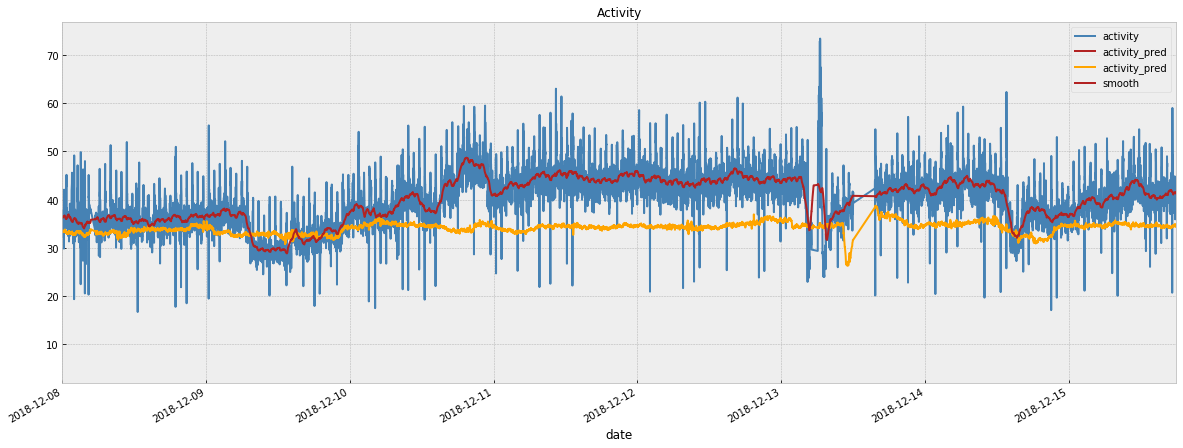

In [32]:
import scipy.signal as sig

plt.rcParams['figure.figsize'] = (16, 6)

tr_data["activity"].plot(ax=plt.gca(), c="steelblue")
cv_data["activity"].plot(ax=plt.gca(), c="steelblue", label="")
tr_preds.plot(ax=plt.gca(), c="firebrick")
cv_preds.plot(ax=plt.gca(), c="orange")

#smooth = pd.Series(cv_data.activity.rolling(25, min_periods=1).mean().values , index=cv_data.index, name="smooth")
smooth = pd.Series(sig.savgol_filter(cv_data.activity.values, 91, 1) , index=cv_data.index, name="smooth")
smooth.plot(c='firebrick')
#tr_data.activity.rolling(5, min_periods=1).mean().plot(c='blue')

plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)
#plt.xlim('2018-11-01 00:00', '2018-11-02 00:00')
#plt.xlim('2018-11-06 06:00', '2018-11-06 12:00')

#plt.xlim('2018-10-23 00:00', '2018-12-31 05:00')
plt.xlim('2018-12-08 00:00', '2018-12-15 18:00')


Text(0, 0.5, 'predicted activity')

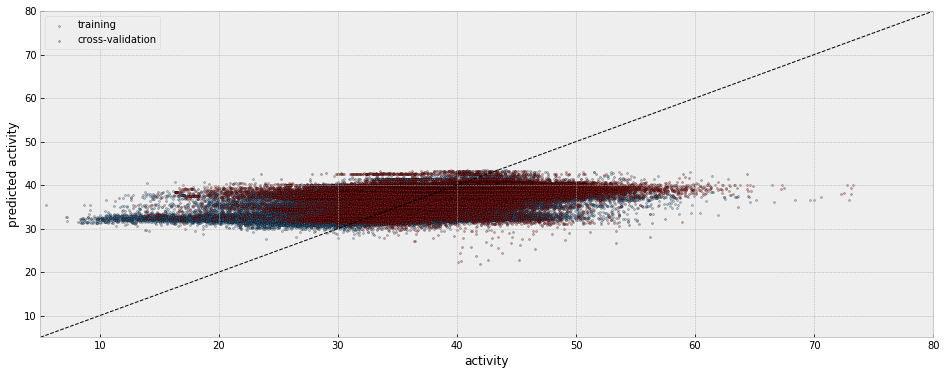

In [0]:
plt.scatter(tr_data.activity.values[WINDOW:], tr_preds, s=4, alpha=0.4, edgecolor="k", c="steelblue", label="training")
plt.scatter(cv_data.activity.values[WINDOW:], cv_preds, s=4, alpha=0.4, edgecolor="k", c="firebrick", label="cross-validation")

plt.xlim(5, 80)
plt.ylim(5, 80)
plt.legend(loc=0)
plt.plot([5, 80], [5, 80], "--", c="k", linewidth=1)
plt.xlabel("activity")
plt.ylabel("predicted activity")

In [0]:
print(f"MAPE (training set): {100 * mape(tr_data['activity'].values, tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(cv_data['activity'].values, cv_preds.values):.2f}%")

MAPE (training set): 10.12%
MAPE (cross-validation set): 9.35%


Наша модель недостаточно хорошо справляется со слишком большими и слишком маленькими значениями целевой переменной. Подумайте, как это исправить.

In [0]:
test_activity_data = activity_test_target.join(full_data.shift(6, freq="H")).ffill()
ts_preds = model.predict((test_activity_data.values - center)/scale) * tr_data["activity"].std() + tr_data["activity"].mean()

ts_preds = pd.DataFrame(ts_preds, columns=["activity"], index=activity_test_target.index)
ts_preds.loc[activity_test_target.index].to_csv(DATA_DIR.joinpath("activity_nn_baseline.csv"))

# Атактика

В случае атактики у нас есть намного меньше данных. Будем предполагать, что сеть для прогноза активности катализатора строит представление, которые релевантные и для прогноза атактики.

In [0]:
encoder_model = keras.Model(inputs=model.input,
                            outputs=model.get_layer("dense").output)

In [0]:
tr_enc = encoder_model.predict(trn)
cv_enc = encoder_model.predict(cvn)

In [0]:
tr_enc.shape

(216400, 32)

In [0]:
tr_df = pd.DataFrame(tr_enc, columns=[f"enc{i}" for i in range(tr_enc.shape[1])], index=tr_data.index)
cv_df = pd.DataFrame(cv_enc, columns=[f"enc{i}" for i in range(cv_enc.shape[1])], index=cv_data.index)

Признаки уже сдвинуты на 6 часов, поэтому их не нужно сдвигать снова:

In [0]:
atactic_data = train_targets[ACOLS].join(pd.concat([tr_df, cv_df]))

In [0]:
atactic_data = atactic_data[atactic_data.notnull().all(axis=1)]

In [0]:
atactic_data

In [0]:
at_tr_data = atactic_data[:"2018-11-15"]
at_cv_data = atactic_data["2018-11-16":]

## Тривиальные бенчмарки

In [0]:
mapes = []

for cl in ACOLS:
    local_mape = mape(at_cv_data[cl], at_tr_data[cl].iloc[-1])
    mapes.append(local_mape)
    
print(f"MAPE (last known value, cross-validation set): {100 * np.mean(mapes):.2f}%")

mapes = []

for cl in ACOLS:
    local_mape = mape(at_cv_data[cl], at_tr_data[cl].median())
    mapes.append(local_mape)

print(f"MAPE (median, cross-validation set): {100 * np.mean(mapes):.2f}%")

MAPE (last known value, cross-validation set): 18.68%
MAPE (median, cross-validation set): 22.77%


In [0]:
naive_baseline = atactic_test_target.copy()

for cl in ACOLS:
    naive_baseline[cl] = at_tr_data[cl].iloc[-1]
naive_baseline.to_csv(DATA_DIR.joinpath("atactic_naive_baseline.csv"))

## Модели

In [0]:
from sklearn.linear_model import LinearRegression, ARDRegression
from sklearn.ensemble import RandomForestRegressor

In [0]:
tsn = (test_activity_data.values - center)/scale
ts_enc = encoder_model.predict(tsn)
ts_df = pd.DataFrame(ts_enc, columns=[f"enc{i}" for i in range(ts_enc.shape[1])], index=test_activity_data.index)

ts_atactic_data = atactic_test_target.join(ts_df)

Target atactic_1:
	MAPE atactic_1 (training set): 12.86%
	MAPE atactic_1 (cross-validation set): 17.12%


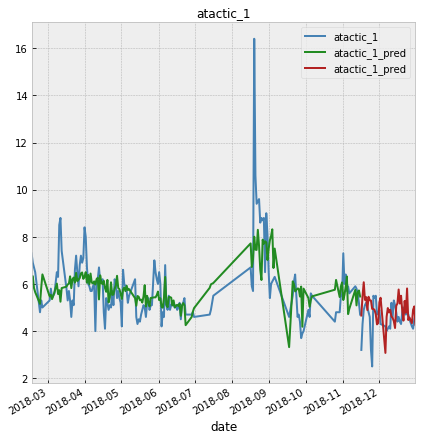

Target atactic_2:
	MAPE atactic_2 (training set): 13.95%
	MAPE atactic_2 (cross-validation set): 16.90%


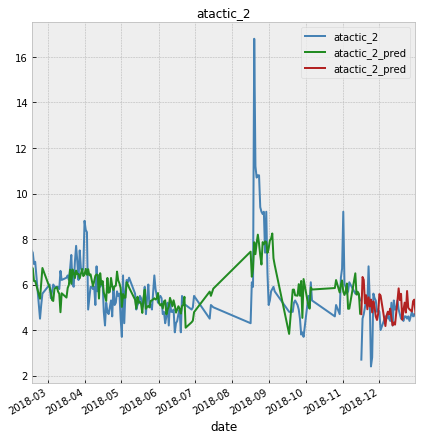

Target atactic_3:
	MAPE atactic_3 (training set): 12.26%
	MAPE atactic_3 (cross-validation set): 20.66%


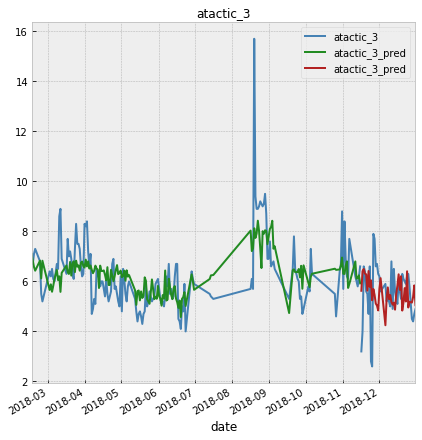

MAPE (training set): 13.02%
MAPE (cross-validation set): 18.23%


In [0]:
tr_mapes = []
cv_mapes = []
ts_preds = atactic_test_target.copy()

for cl in ACOLS:
    model =  ARDRegression()

    model.fit(at_tr_data.iloc[:, 3:], at_tr_data[cl])

    tr_preds = model.predict(at_tr_data.iloc[:, 3:])
    cv_preds = model.predict(at_cv_data.iloc[:, 3:])

    print(f"Target {cl}:")
    print(f"\tMAPE {cl} (training set): {100 * mape(at_tr_data[cl], tr_preds):.2f}%")
    print(f"\tMAPE {cl} (cross-validation set): {100 * mape(at_cv_data[cl], cv_preds):.2f}%")

    tr_mapes.append(mape(at_tr_data[cl], tr_preds))
    cv_mapes.append(mape(at_cv_data[cl], cv_preds))

    tr_preds = pd.Series(tr_preds, index=at_tr_data.index, name=f"{cl}_pred")
    cv_preds = pd.Series(cv_preds, index=at_cv_data.index, name=f"{cl}_pred")

    at_tr_data[cl].plot(c="steelblue")
    at_cv_data[cl].plot(c="steelblue", label="")
    tr_preds.plot(c="forestgreen")
    cv_preds.plot(c="firebrick")
    plt.legend(loc=0)
    plt.tight_layout()
    plt.title(cl, fontsize=12)
    plt.show()

    ts_preds[cl] = model.predict(ts_atactic_data)

print(f"MAPE (training set): {100 * np.mean(tr_mapes):.2f}%")
print(f"MAPE (cross-validation set): {100 * np.mean(cv_mapes):.2f}%")

In [0]:
ts_preds.to_csv(DATA_DIR.joinpath("atactic_nn_baseline.csv"))

In [0]:
feature;description;units	 
f0;Уровень донора в нефрасe ;%	 
f1;Тем-ра пропилена к к.201;К	 
f2;Расход пропилена к R1;л/c	 
f3;Расход водорода к R1;л/c	 
f4;Расход катализатора в R1;л/c	 
f5;Расход донора к R1;л/c	 
f6;Давление пропилена на входе;Па	 
f7;Давление в газовой фазе реактора R1;Па	 
f8;R1	Объемная доля пропана;%
f9;R1	Объемная доля водорода;%
f10;Расход пропилена к R2;л/c	 
f11;Расход водорода к R2;л/c	 
f12;Расход катализатора в R2;л/c	 
f13;Расход донора к R2;л/c	 
f14;Давление в газовой фазе реактора R2;Па	 
f15;R2	Объемная доля пропана;%
f16;R2	Объемная доля водорода;%
f17;Температура реакционной среды в R1;К	 
f18;Температура реакционной среды в R2;К	 
f19;Температура реакционной среды в R3;К	 
f20;Расход нефраса к R1;л/c	 
f21;Расход нефраса к R2;л/c	 
f22;Расход ТЭА к R1;л/c	 
f23;Расход ТЭА к R2;л/c	 
f24;Температура в D219;К	 
f25;R1	Газоанализатор водорода;%
f26;R2	Газоанализатор водорода;%
f27;R3	Газоанализатор водорода;%
f28;ТЭА;л/c	 
f29;R1	Ток мешалки;А
f30;R3	Ток мешалки;А
f31;R2	Ток мешалки;А
f32;R1	Уровень;%
f33;R3	Уровень;%
f34;R2	Уровень;%
f35;Давление азота к E3B;Па	 
f36;R3	Перепад давления масло : газ;Па
f37;Давление сдувок на этилен;Па	 
f38;Температура деминерализованной воды;К	 
f39;Температура суспензии внизу R1;К	 
f40;Температура суспензии внизу R3;К	 
f41;Температура суспензии в центре R1;К	 
f42;Температура воздуха;К	 
f43;Атмосферное давление;Па	 
f44;Влажность воздуха;%	 
f45;Температура суспензии в центре R3;К	 
f46;Температура R1 длинный терм.;К	 
f47;Температура R1 короткий терм.;К	 
f48;Температура R3 длинный терм.;К	 
f49;Температура R3 короткий терм.;К	 
f50;Температура суспензии в центре R2;К	 
f51;Температура R2 длинный терм.;К	 
f52;Температура R2 короткий терм.;К	 
f53;Д18А Датчики веса;кг	 
f54;Д19А Датчики веса;кг	 
f55;Д20А Датчики веса;кг	 

In [0]:
nodes = 16

input = layers.Input(shape=(WINDOW, len(FTS_COLS)))
l1a = l1b = layers.Conv1D(nodes, kernel_size=2, dilation_rate=1, padding='same')(input)    
l2a = l2b = layers.Conv1D(nodes, kernel_size=2, dilation_rate=2, padding='same')(l1a) 
l3a = l3b = layers.Conv1D(nodes, kernel_size=2, dilation_rate=4, padding='same')(l2a)
l4a = l4b = layers.Conv1D(nodes, kernel_size=2, dilation_rate=8, padding='same')(l3a)
l5a = l5b = layers.Conv1D(nodes, kernel_size=2, dilation_rate=16, padding='same')(l4a)
l5b = layers.Dropout(0.8)(l5b) #dropout used to limit influence of earlier data
l6a = l6b = layers.Conv1D(nodes, kernel_size=2, dilation_rate=32, padding='same')(l5a)
l6b = layers.Dropout(0.8)(l6b) #dropout used to limit influence of earlier data

l8 =   layers.Add()([l1b, l2b, l3b, l4b, l5b, l6b])
  
l9 =  layers.Conv1D(1,1, activation='linear', use_bias=False)(l8)
l10 =  layers.Flatten()(l9)
l11 =   layers.Dense(1, activation='relu')(l10)

model = keras.Model(input, l11)